#### PASO 1: CONFIGURACIÓN DEL ENTORNO E IMPORTACIÓN DE LIBRERÍAS

In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression  # (Para el ejemplo final)
from sklearn.metrics import mean_squared_error   # (Para el ejemplo final)

# Cargar los datos
file_path = '../cleaned_main_financial_metrics.csv'
df = pd.read_csv(file_path)
display(df.head())


,recommendationKey,recommendationMean,numberOfAnalystOpinions,shortName,symbol,Ticker,sector,state,fullExchangeName,In_SP500,...,sharesPercentSharesOut,shortRatio,shortPercentOfFloat,heldPercentInsiders,heldPercentInstitutions,fullTimeEmployees,is_Insolvent,_debtToEquity,has_benefits,_PER
0,strong_buy,1.32000,22.0,S&P Global Inc.,SPGI,SPGI,Financial Services,NY,NYSE,True,...,0.0101,1.98,0.0101,0.00253,0.90520,42350.0,0,1.098585e+08,0,36.371253
1,buy,2.25000,17.0,General Dynamics Corporation,GD,GD,Industrials,VA,NYSE,True,...,0.0100,2.39,0.0112,0.00508,0.86690,117000.0,0,1.209563e+08,0,22.224832
2,strong_buy,1.45455,11.0,"Life Time Group Holdings, Inc.",LTH,LTH,Consumer Cyclical,MN,NYSE,False,...,0.0345,3.66,0.0573,0.12613,0.80370,49000.0,0,3.135195e+08,0,25.196078
3,buy,2.00000,30.0,Veeva Systems Inc.,VEEV,VEEV,Healthcare,CA,NYSE,False,...,0.0325,4.06,0.0355,0.08521,0.88599,7291.0,0,2.109358e+06,0,58.501031
4,hold,2.97059,27.0,lululemon athletica inc.,LULU,LULU,Consumer Cyclical,BC,NasdaqGS,True,...,0.0725,1.07,0.0993,0.04617,0.88831,39000.0,0,4.778956e+07,0,11.427304


#### PASO 2: CARGA DE DATOS

Vamos a cargar las métricas financieras de diferentes empresas que cotizan en la bolsa NYSE y el NASDAQ


In [ ]:
# 1. Definir el Target
TARGET_COL = 'recommendationMean'

# 2. Definir columnas a excluir
# (Identificadores, texto libre, o 'leaks' de la variable target)
EXCLUDE_COLS = [
    TARGET_COL, 
    'recommendationKey', # 'recommendationKey' está directamente relacionado con el target
    'shortName', 'symbol', 'Ticker', 'fullExchangeName' # Son identificadores
]

# 3. Identificar tipos de features (basado en el df.info())
# Filtramos las columnas que no están en EXCLUDE_COLS

# Columnas Numéricas (float64)
NUMERIC_FEATURES = [
    'numberOfAnalystOpinions', 'currentPrice', 'beta', 'marketCap', 'enterpriseValue',
    'priceToBook', 'enterpriseToRevenue', 'profitMargins', 'grossMargins', 'ebitdaMargins',
    'operatingMargins', 'returnOnAssets', 'returnOnEquity', 'revenueGrowth', 'totalRevenue',
    'revenuePerShare', 'grossProfits', 'ebitda', 'netIncomeToCommon', 'trailingEps',
    'totalCash', 'totalCashPerShare', 'totalDebt', 'quickRatio', 'currentRatio',
    'bookValue', 'operatingCashflow', 'freeCashflow', 'trailingAnnualDividendYield',
    'payoutRatio', 'sharesOutstanding', 'floatShares', 'sharesShort', 'sharesPercentSharesOut',
    'shortRatio', 'shortPercentOfFloat', 'heldPercentInsiders', 'heldPercentInstitutions',
    'fullTimeEmployees', '_debtToEquity', '_PER'
    # Nota: Se podrían excluir más columnas si se considera necesario (ej. 'allTimeHigh')
]

# Columnas Categóricas (object, bool, o int que actúa como bool)
CATEGORICAL_FEATURES = [
    'sector', 'state', 'In_SP500', 'In_NASDAQ', 'is_Insolvent', 'has_benefits'
]

# 4. Crear X (features) e y (target)
y = df[TARGET_COL]
X = df[NUMERIC_FEATURES + CATEGORICAL_FEATURES]

print(f"Forma de X (features): {X.shape}")
print(f"Forma de y (target): {y.shape}")

print("\n--- Ejemplo de Features (X) antes del pre-procesamiento ---")
print(X.head())

,state,industry,sector,fullTimeEmployees,regularMarketOpen,payoutRatio,beta,averageVolume,marketCap,allTimeHigh,...,Total Debt_2021-12-31 00:00:00,Working Capital_2021-12-31 00:00:00,Operating Cash Flow_2024-12-31 00:00:00,Capital Expenditure_2024-12-31 00:00:00,Operating Cash Flow_2023-12-31 00:00:00,Capital Expenditure_2023-12-31 00:00:00,Operating Cash Flow_2022-12-31 00:00:00,Capital Expenditure_2022-12-31 00:00:00,Operating Cash Flow_2021-12-31 00:00:00,Capital Expenditure_2021-12-31 00:00:00
0,NY,Financial Data & Stock Exchanges,Financial Services,42350.0,473.54,0.2875,1.189,1409834.0,1.444649e+11,579.05,...,4.702000e+09,4.995000e+09,5.689000e+09,-124000000.0,3.710000e+09,-143000000.0,2.603000e+09,-8.900000e+07,3.598000e+09,-35000000.0
1,VA,Aerospace & Defense,Industrials,117000.0,328.92,0.3922,0.484,1044250.0,8.907715e+10,347.37,...,1.317500e+10,6.009000e+09,4.112000e+09,-916000000.0,4.710000e+09,-904000000.0,4.579000e+09,-1.114000e+09,4.271000e+09,-887000000.0
2,MN,Leisure,Consumer Cyclical,49000.0,25.14,0.0000,1.702,2283057.0,5.653900e+09,34.99,...,3.756818e+09,-2.747280e+08,5.751170e+08,-524535000.0,4.630040e+08,-697993000.0,2.009690e+08,-5.911780e+08,-2.002900e+07,-328909000.0
3,CA,Health Information Services,Healthcare,7291.0,291.19,0.0000,0.982,1325242.0,4.650562e+10,343.96,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,BC,Apparel Retail,Consumer Cyclical,39000.0,162.98,0.0000,1.072,4981781.0,1.985301e+10,516.39,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
df["missing_count"] = df.isna().sum(axis=1)

# 2️⃣ Contar cuántas filas tienen 0, 1, 2, 3... NaN
resumen = df["missing_count"].value_counts().sort_index()

# 3️⃣ Mostrar resultado
print(resumen)

missing_count
0     732
1     346
2      98
3      63
4      78
5      53
6      22
7      20
8      28
9      16
10    127
11     65
12      8
13      7
14      5
15     10
16      4
17      3
22      1
24      2
25      1
26      1
28    220
29     75
30     17
31     11
32      2
33      3
34      8
35      7
36      2
42      1
68      1
Name: count, dtype: int64


In [4]:
filas_antes = len(df)
df_filt = df[df.isna().sum(axis=1) <= 15].copy()
filas_despues = len(df_filt)

print(f"Filas eliminadas: {filas_antes - filas_despues}")
print(f"Filas restantes: {filas_despues}")


Filas eliminadas: 359
Filas restantes: 1678


#### PASO 3: ANÁLISIS EXPLORATORIO DE DATOS (EDA)

El EDA es fundamental para entender la estructura, la calidad y las relaciones en los datos.



--- Iniciando Análisis Exploratorio de Datos (EDA) ---

Información general del DataFrame (df.info()):
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2037 entries, 0 to 2036
Data columns (total 95 columns):
 #   Column                                                       Non-Null Count  Dtype  
---  ------                                                       --------------  -----  
 0   state                                                        1947 non-null   object 
 1   industry                                                     2036 non-null   object 
 2   sector                                                       2036 non-null   object 
 3   fullTimeEmployees                                            2002 non-null   float64
 4   regularMarketOpen                                            2037 non-null   float64
 5   payoutRatio                                                  2035 non-null   float64
 6   beta                                                         198

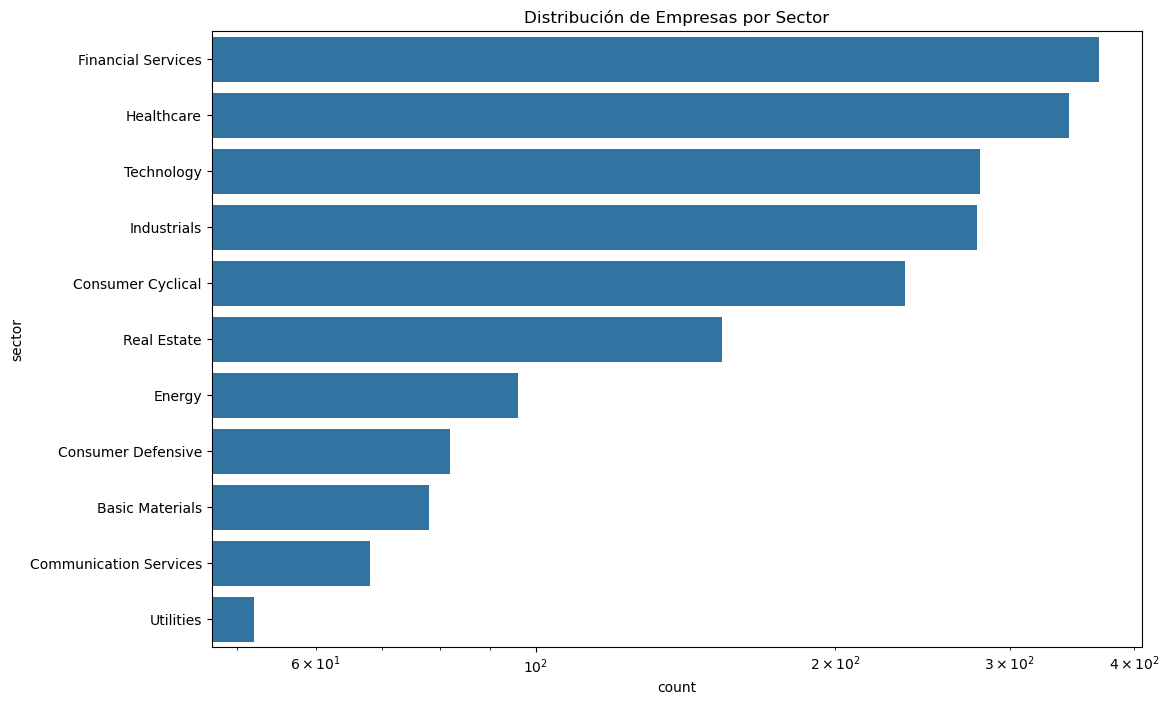

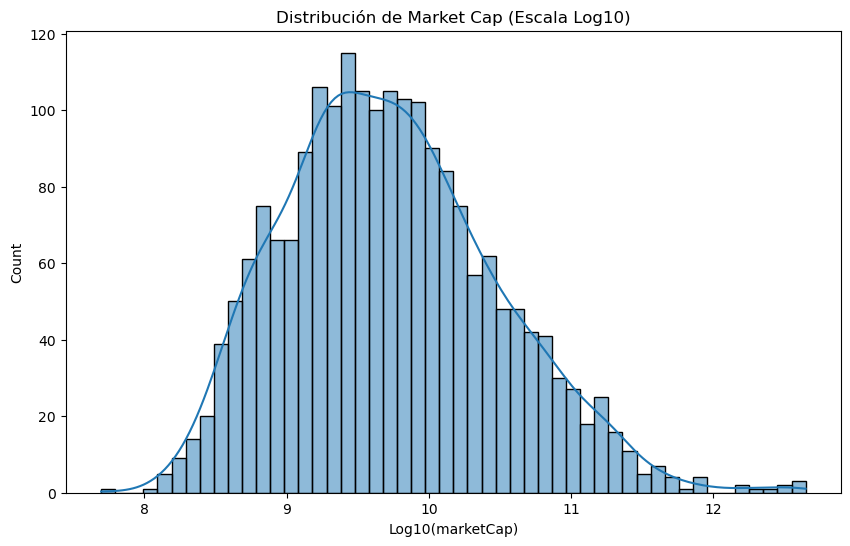


Realizando análisis bivariado...


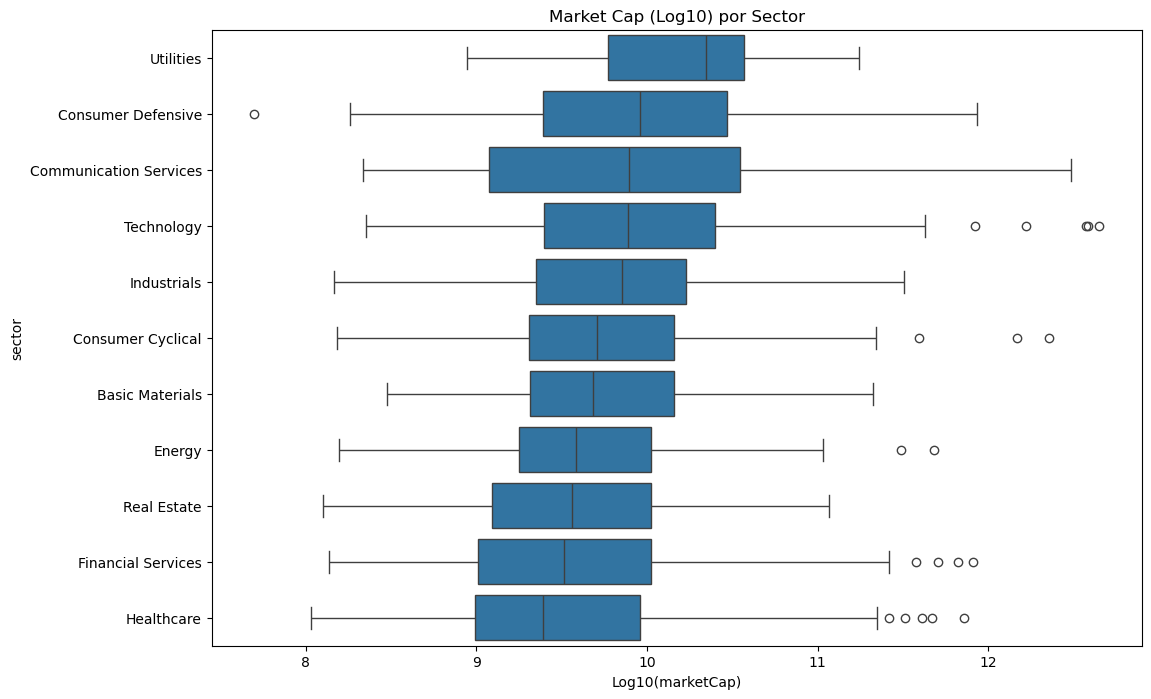


Calculando matriz de correlación...


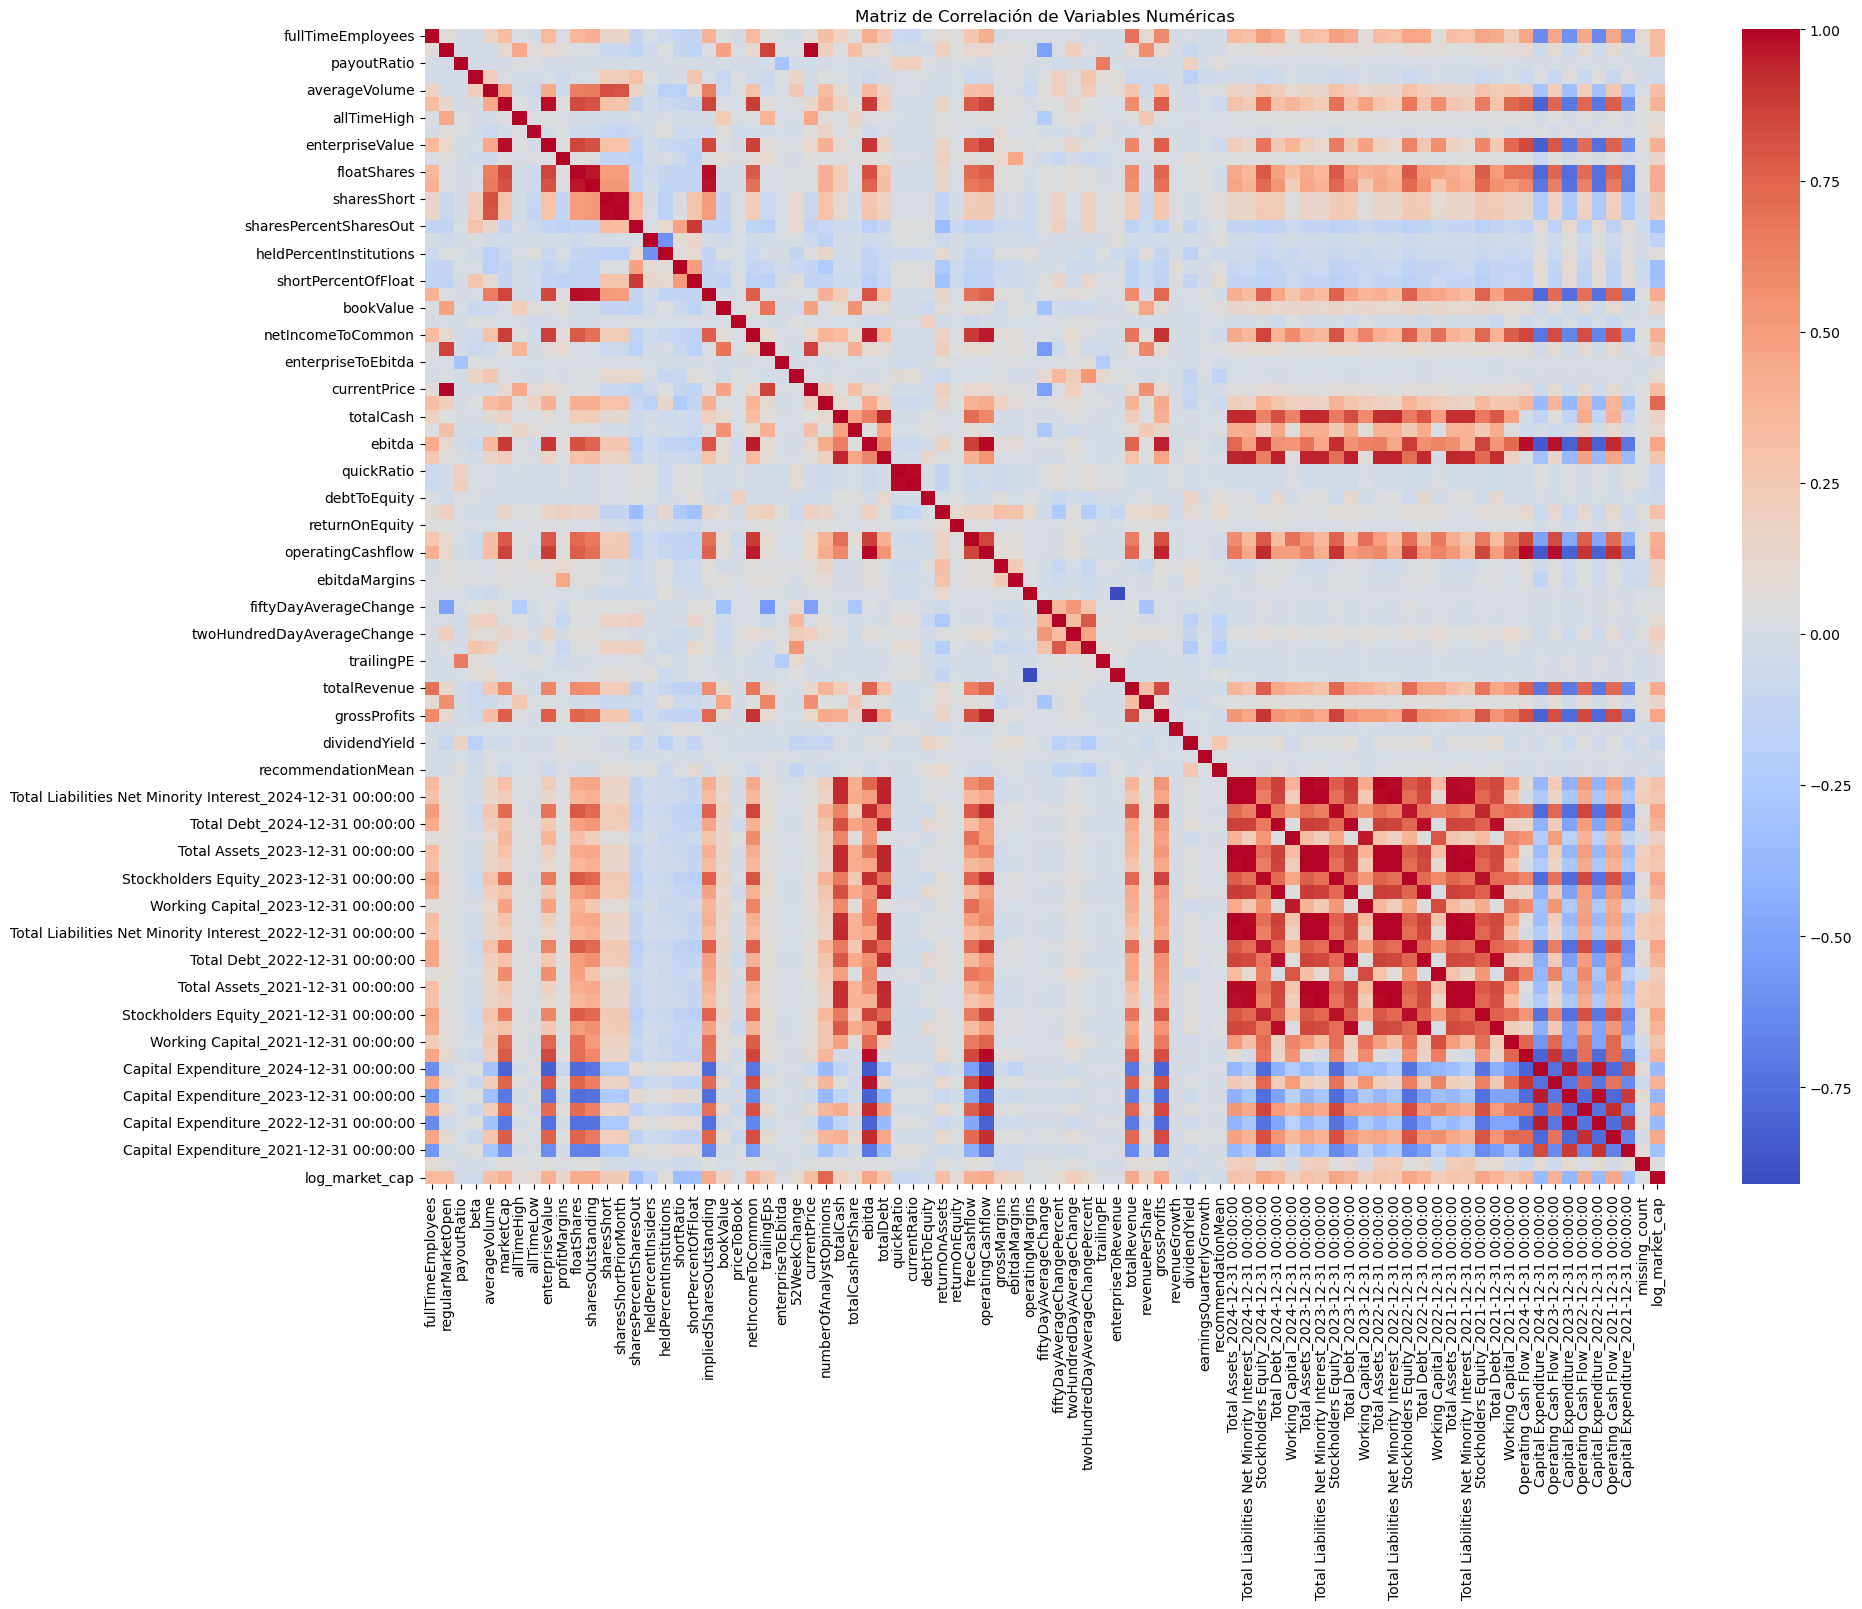

In [5]:
print("\n--- Iniciando Análisis Exploratorio de Datos (EDA) ---")

# 3.1. Información General del Dataset
print("\nInformación general del DataFrame (df.info()):")
df.info(verbose=True, show_counts=True)

# 3.2. Resumen Estadístico de Variables Numéricas
print("\nResumen estadístico de variables numéricas (df.describe()):")
print(df.describe())

# 3.3. Análisis de Valores Nulos
print("\nConteo de valores nulos por columna (top 20):")
print(df.isnull().sum().sort_values(ascending=False).head(20))


# 3.4. Análisis Univariado
print("\nRealizando análisis univariado...")

# Nuestra variable objetivo: 'sector'
plt.figure(figsize=(12, 8))
# Eliminamos filas con sector nulo para el gráfico
sns.countplot(y='sector', data=df.dropna(subset=['sector']), order = df['sector'].value_counts().index)
plt.title('Distribución de Empresas por Sector')
plt.xscale('log') # Escala logarítmica para mejor visualización si hay mucho desbalance
plt.show()

# Distribución de MarketCap (usando escala logarítmica)
plt.figure(figsize=(10, 6))
sns.histplot(np.log10(df['marketCap'].dropna() + 1), kde=True, bins=50)
plt.title('Distribución de Market Cap (Escala Log10)')
plt.xlabel('Log10(marketCap)')
plt.show()

# 3.5. Análisis Bivariado
print("\nRealizando análisis bivariado...")

# MarketCap vs. Sector
plt.figure(figsize=(12, 8))
df['log_market_cap'] = np.log10(df['marketCap'] + 1)
# Ordenamos los sectores por su capitalización de mercado mediana
sector_order = df.groupby('sector')['log_market_cap'].median().sort_values(ascending=False).index
sns.boxplot(x='log_market_cap', y='sector', data=df, order=sector_order)
plt.title('Market Cap (Log10) por Sector')
plt.xlabel('Log10(marketCap)')
plt.show()


# 3.6. Matriz de Correlación
print("\nCalculando matriz de correlación...")
numeric_cols = df.select_dtypes(include=np.number)
correlation_matrix = numeric_cols.corr()

plt.figure(figsize=(20, 15))
sns.heatmap(correlation_matrix, cmap='coolwarm')
plt.title('Matriz de Correlación de Variables Numéricas')
plt.show()



#### PASO 4: PREPROCESAMIENTO DE DATOS E INGENIERÍA DE CARACTERÍSTICAS

Eliminamos columnas que no aportan información útil o son difíciles de tratar, con muchos missing values


In [6]:
print("\n--- Iniciando Preprocesamiento de Datos ---")

# Eliminamos filas donde nuestra variable objetivo ('sector') es nula.
df.dropna(subset=['sector'], inplace=True)
# Rellenamos 'state' con 'Unknown' para no perder filas.
df['state'] = df['state'].fillna('Unknown')


# Eliminamos columnas que no son útiles para el modelo:
# - Identificadores únicos (Ticker, symbol, shortName)
# - Columnas que "filtran" información futura o son opiniones (recommendationKey, averageAnalystRating)
# - Columnas con demasiados valores nulos o categóricas con demasiada cardinalidad (industry)
# - Columnas con fechas en el nombre que no podemos usar directamente.
# - Columnas booleanas de pertenencia a índices
cols_to_drop = [
    'Ticker', 'symbol', 'shortName', 'fullExchangeName', 'recommendationKey',
    'averageAnalystRating', 'industry', 'In_SP500', 'In_NASDAQ', 'log_market_cap'
]
# Eliminamos dinámicamente columnas que parecen fechas
date_like_cols = [col for col in df.columns if '202' in col]
cols_to_drop.extend(date_like_cols)

df_processed = df.drop(columns=cols_to_drop, errors='ignore').copy()

# Separamos la variable objetivo (y) de las predictoras (X)
X = df_processed.drop('sector', axis=1)
y = df_processed['sector']

# Identificamos columnas numéricas y categóricas
numerical_features = X.select_dtypes(include=np.number).columns
categorical_features = X.select_dtypes(include=['object', 'category', 'bool']).columns

print(f"Columnas numéricas ({len(numerical_features)}) encontradas.")
print(f"Columnas categóricas ({len(categorical_features)}): {list(categorical_features)}")

# Creamos pipelines de preprocesamiento para cada tipo de dato
numerical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')), # Mediana es más robusta a outliers
    ('scaler', StandardScaler())
])

categorical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# Usamos ColumnTransformer para aplicar los pipelines a las columnas correctas
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_pipeline, numerical_features),
        ('cat', categorical_pipeline, categorical_features)
    ], remainder='passthrough')

# Dividimos los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print(f"\nDatos divididos: {len(X_train)} para entrenamiento, {len(X_test)} para prueba.")






--- Iniciando Preprocesamiento de Datos ---
Columnas numéricas (56) encontradas.
Columnas categóricas (1): ['state']

Datos divididos: 1628 para entrenamiento, 408 para prueba.


In [7]:
#### PASO 5: ENTRENAMIENTO Y EVALUACIÓN DE MODELOS



In [8]:
print("\n--- Entrenando y Evaluando Modelos ---")

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42)
}

results = {}
for name, model in models.items():
    model_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                     ('classifier', model)])
    print(f"Entrenando {name}...")
    model_pipeline.fit(X_train, y_train)
    y_pred = model_pipeline.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    results[name] = accuracy
    print(f"--- Accuracy para {name}: {accuracy:.4f} ---")



--- Entrenando y Evaluando Modelos ---
Entrenando Logistic Regression...


ValueError: Input X contains infinity or a value too large for dtype('float64').


--- Comparación Final de Modelos ---
                    Model  Accuracy
2  Support Vector Machine  0.815642
4           Random Forest  0.815642
5       Gradient Boosting  0.815642
0     Logistic Regression  0.804469
1     K-Nearest Neighbors  0.804469
3           Decision Tree  0.793296


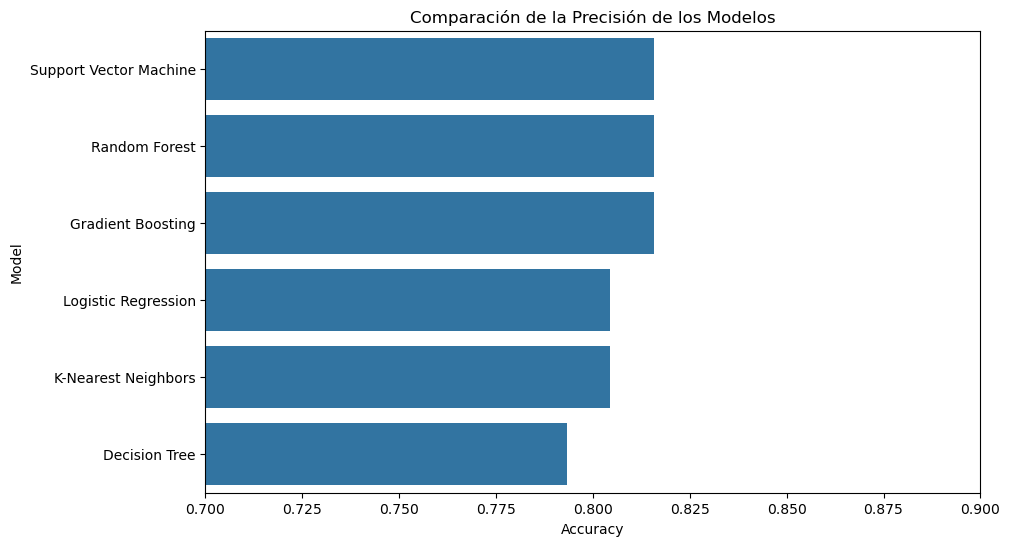


Análisis finalizado.
El modelo con mejor rendimiento inicial es el Gradient Boosting.
El siguiente paso podría ser la optimización de hiperparámetros para este modelo.


In [ ]:
print("\n--- Comparación Final de Modelos ---")
results_df = pd.DataFrame(list(results.items()), columns=['Model', 'Accuracy']).sort_values(by='Accuracy', ascending=False)
print(results_df)

plt.figure(figsize=(10, 6))
sns.barplot(x='Accuracy', y='Model', data=results_df, palette='viridis')
plt.title('Comparación de la Precisión de los Modelos')
if results:
    plt.xlim(min(results.values()) * 0.95, max(results.values()) * 1.02)
plt.show()

print("\nAnálisis finalizado.")
if not results_df.empty:
    best_model_name = results_df.iloc[0]['Model']
    print(f"El modelo con mejor rendimiento inicial es el {best_model_name}.")
    print("El siguiente paso podría ser la optimización de hiperparámetros para este modelo (usando GridSearchCV).")
